# Pipeline Jupyter Notebook

Used to walk through the separate steps of the fine-tuning process. Each individual component can be swapped without affecting the others. All together, this jupyter notebook is a fine-tuning pipeline for ClimaX.

The steps in order are:
1. Download the dataset
2. Split labels from the features if necessary (ClimateNet needs this, but other datasets may not)
3. Normalize the dataset to 0-mean and 1-std
4. Visualize the data for funsies
5. Regrid the dataset to fit the input layer of ClimaX
6. Visualize the data again for even more funsies
7. Perform Architectural Modifications to ClimaX
8. Fine-tune ClimaX with our custom losses, collect performance statistics, and save the model weights


These modules are built to be as general as possible so that minimal modification needs to be done to use another dataset / architectural changes / objective functions etc...
However, some of the simpler modules (like splitting the data into features and labels) are fairly specialized for ClimateNet

In [ ]:
# module I created to easily leverage the linux wget command
import downloader

# download all train data from the ClimateNet dataset
downloader.download('https://portal.nersc.gov/project/ClimateNet/climatenet_new/train/', '/localhome/ophirsim/train', 'nc')

# download all test data from the ClimateNet dataset
downloader.download('https://portal.nersc.gov/project/ClimateNet/climatenet_new/test/', '/localhome/ophirsim/test', 'nc')


# Split data into features and labels

The ClimateNet data places the features and the label into the same file. Combine all the files into train_X.npy, train_y.npy, test_X.npy, text_y.npy files, where the train / test data is separated and the feature / label data is separated.

This involves converting nc files into npy files, and reshaping the result to looks like (N, V, H, W) for (Number of samples, Variable, Height, Width)

In [ ]:
# module I created to combine nc files together, separate the features and labels, and reshape the result
import splitter

# split the train and test set into train_X.npy, train_y.npy, test_X.npy, test_y.npy
splitter.split('/localhome/ophirsim/train', '/localhome/ophirsim/train_X.npy', '/localhome/ophirsim/train_y.npy')
splitter.split('/localhome/ophirsim/test', '/localhome/ophirsim/test_X.npy', '/localhome/ophirsim/test_y.npy')


In [13]:
# periodically clean up files we no longer need
import shutil
shutil.rmtree('/localhome/ophirsim/train/')
shutil.rmtree('/localhome/ophirsim/test/')


# Normalize Data

We want to normalize our data to 0-mean, 1-standard deviation for the sake of improved training.

In [ ]:
import normalizer

# apply normalization to make the data arrays all 0-mean and 1-std for each variabled
normalizer.normalize('/localhome/ophirsim/train_X.npy', '/localhome/ophirsim/train_X_normalized.npy', 1)
normalizer.normalize('/localhome/ophirsim/test_X.npy', '/localhome/ophirsim/test_X_normalized.npy', 1)

In [14]:
# periodically clean up files we no longer need
import os
os.remove('/localhome/ophirsim/train_X.npy')
os.remove('/localhome/ophirsim/test_X.npy')

# Visualize the Normalized Data

In [1]:
import numpy as np

# load data_arr and label_arr once, so that it doesn't take a lot of time to load it over and over again
data_arr = np.load('/localhome/ophirsim/train_X_normalized.npy')
label_arr = np.load('/localhome/ophirsim/train_y.npy')


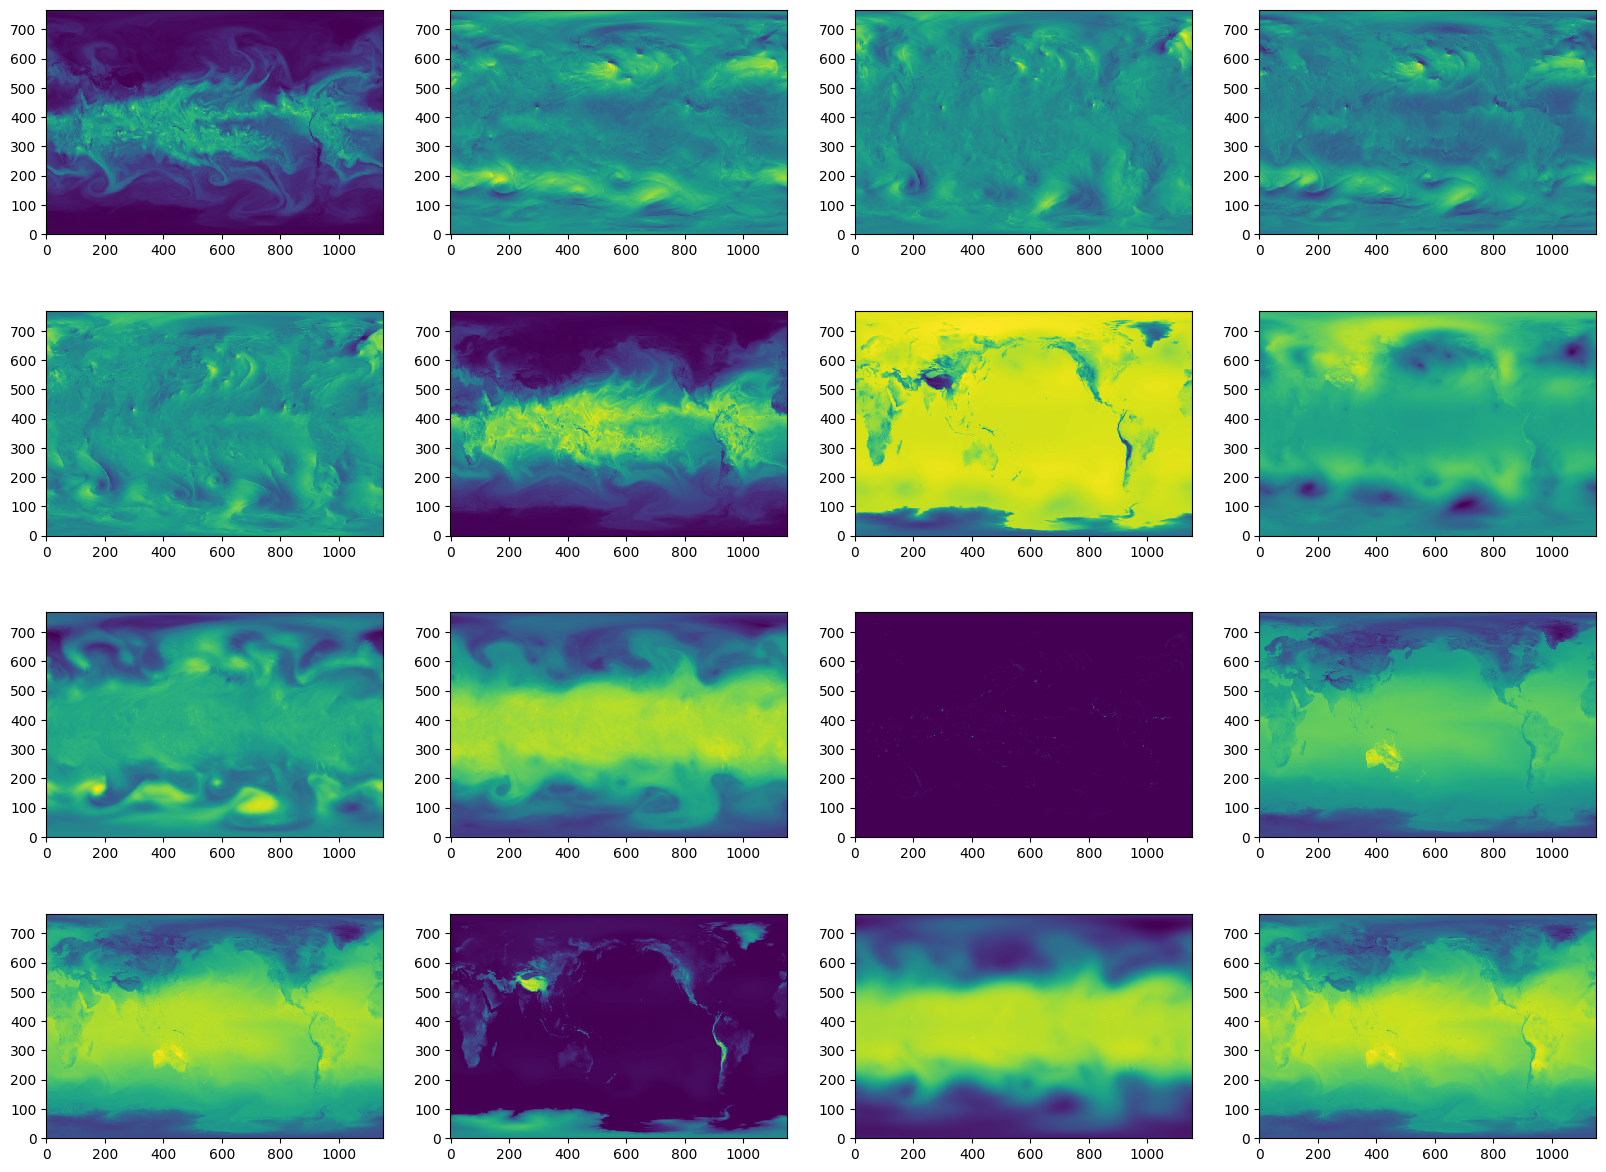

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(20, 15)) 
rows = 4
columns = 4

arbitrary_sample = data_arr[200]

for index, var in enumerate(arbitrary_sample):
    fig.add_subplot(rows, columns, index+1) 
    plt.imshow(var, interpolation='nearest', origin='lower')


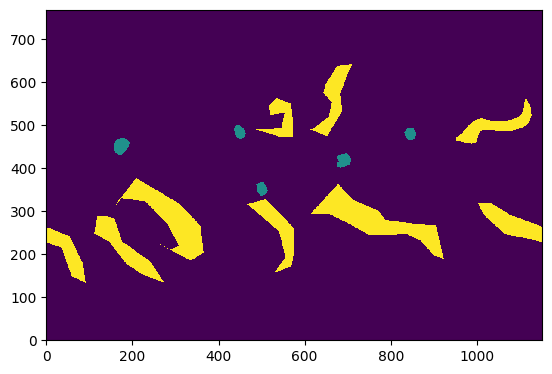

In [3]:
arbitrary_label = label_arr[0]
plt.imshow(arbitrary_label, interpolation='nearest', origin='lower')


# Regrid the Data
We need to change the shape of the images into (128, 256) so that they can fit into the ClimaX input layer. For some datasets, this would mean increasing the resolution of the images, but for ClimateNet, this involves a compression technique. However, we will keep this module as general as possible so that any input can be made into a (128, 256) image

In [9]:
import regridder

# create regridder object
regridder = regridder.regrid((768, 1152), (128, 256), 'nearest_s2d')

# load all files that need regridding
train_X = np.load('/localhome/ophirsim/train_X_normalized.npy')
train_y = np.load('/localhome/ophirsim/train_y.npy')
test_X = np.load('/localhome/ophirsim/test_X_normalized.npy')
test_y = np.load('/localhome/ophirsim/test_y.npy')

In [19]:
# regrid all "images" from each of these files
new_train_X = np.empty((train_X.shape[0], train_X.shape[1], 128, 256))
new_train_y = np.empty((train_y.shape[0], 128, 256))
new_test_X = np.empty((test_X.shape[0], test_X.shape[1], 128, 256))
new_test_y = np.empty((test_y.shape[0], 128, 256))

for i, sample in enumerate(train_X):
    for j, var in enumerate(sample):
        new_train_X[i][j] = regridder(var)

for i, label in enumerate(train_y):
    new_train_y[i] = regridder(label)

for i, sample in enumerate(test_X):
    for j, var in enumerate(sample):
        new_test_X[i][j] = regridder(var)

for i, label in enumerate(test_y):
    new_test_y[i] = regridder(label)

print(new_train_X.shape)
print(new_train_y.shape)
print(new_test_X.shape)
print(new_test_y.shape)

np.save('/localhome/ophirsim/train_X_128x256.npy', new_train_X)
np.save('/localhome/ophirsim/train_y_128x256.npy', new_train_y)
np.save('/localhome/ophirsim/test_X_128x256.npy', new_test_X)
np.save('/localhome/ophirsim/test_y_128x256.npy', new_test_y)



(398, 16, 128, 256)
(398, 128, 256)
(61, 16, 128, 256)
(61, 128, 256)


In [20]:
# periodically clean up files we no longer need
import os
os.remove('/localhome/ophirsim/train_X_normalized.npy')
os.remove('/localhome/ophirsim/train_y.npy')
os.remove('/localhome/ophirsim/test_X_normalized.npy')
os.remove('/localhome/ophirsim/test_y.npy')

# Visualize the Regridded Data

In [21]:
import numpy as np

# load data_arr and label_arr once, so that it doesn't take a lot of time to load it over and over again
data_arr = np.load('/localhome/ophirsim/train_X_128x256.npy')
label_arr = np.load('/localhome/ophirsim/train_y_128x256.npy')

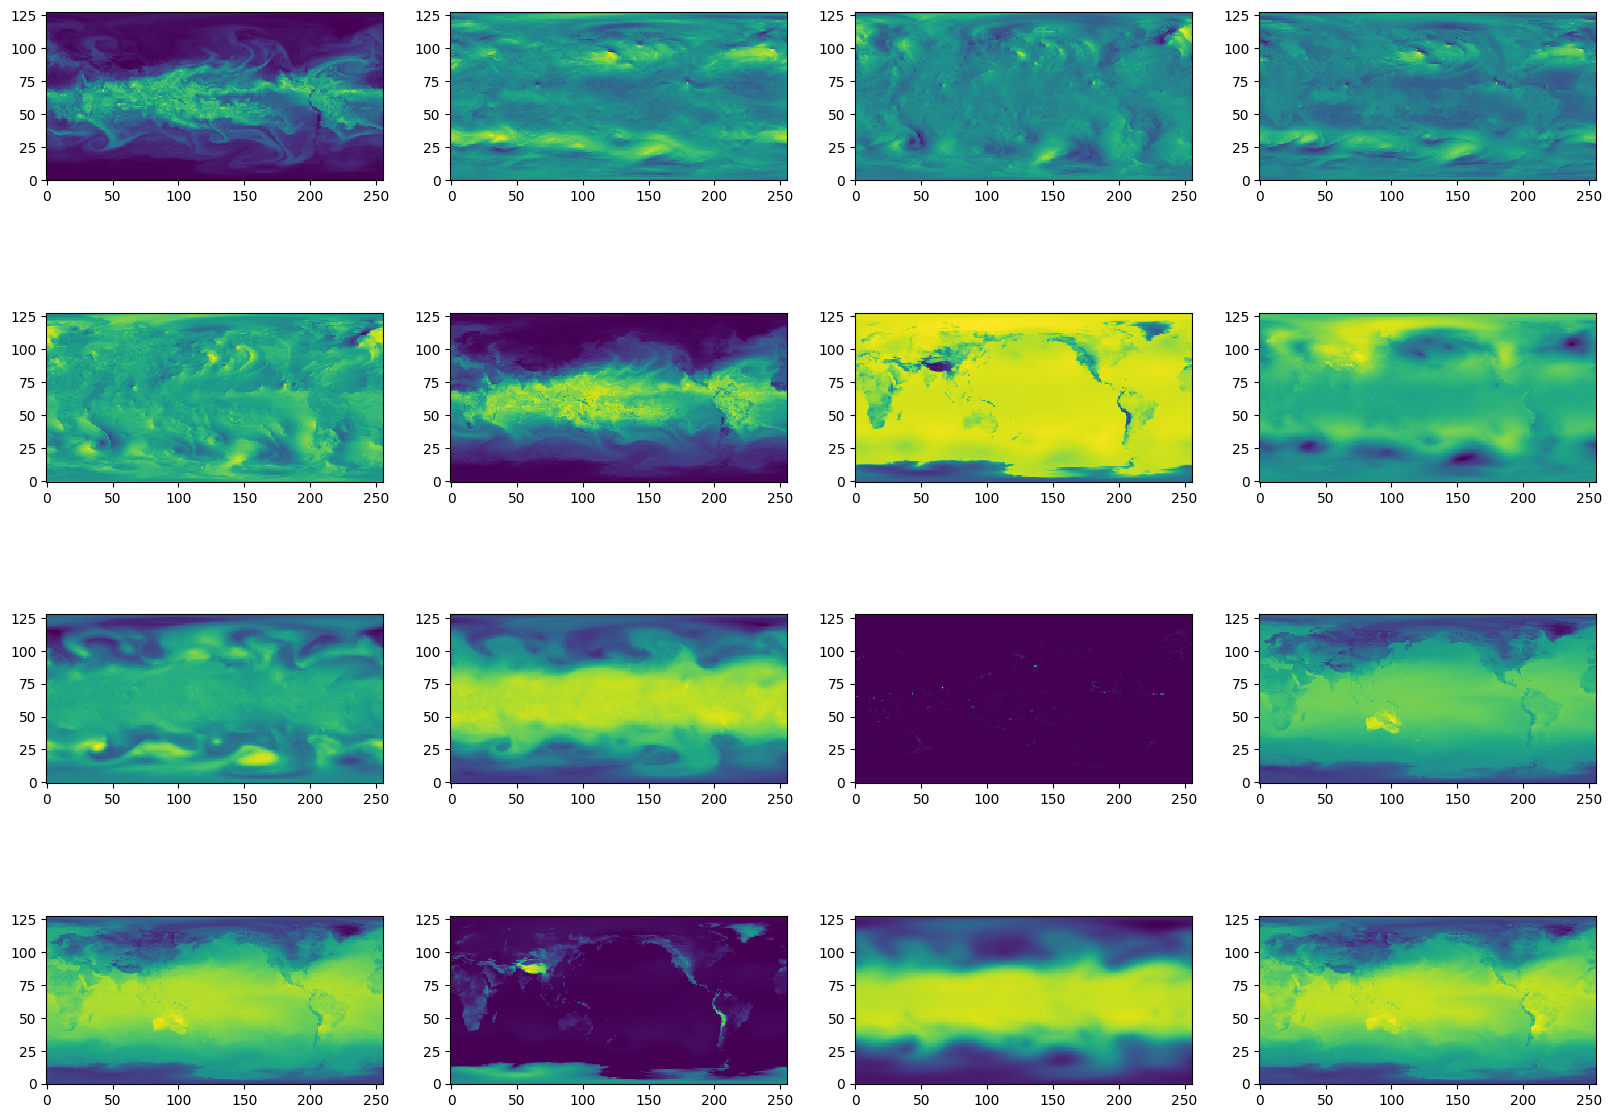

In [22]:
fig = plt.figure(figsize=(20, 15)) 
rows = 4
columns = 4

arbitrary_sample = data_arr[200]

for index, var in enumerate(arbitrary_sample):
    fig.add_subplot(rows, columns, index+1) 
    plt.imshow(var, interpolation='nearest', origin='lower')

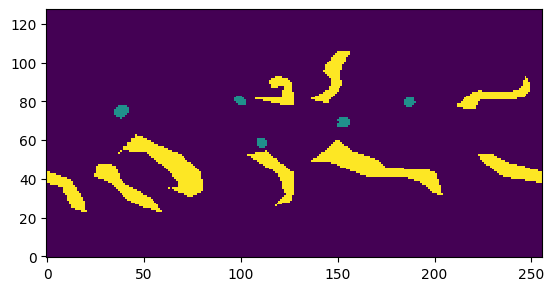

In [23]:
arbitrary_label = label_arr[0]
plt.imshow(arbitrary_label, interpolation='nearest', origin='lower')

# Perform Architectural Changes to ClimaX

Now we need to load a 128x256 pretraiend checkpoint for ClimaX, and modify its architecture in a modularized way